In [1]:
from pmotifs.analysis_utilities.loading import Result
from pmotifs.config import config

GRAPHLET_SIZE = 3

r = Result.load_result(
    config.DATASET_DIRECTORY /  "yeastInter_st.txt",
    config.EXPERIMENT_OUT / "yeastInter_st",
    GRAPHLET_SIZE,
)

g = r.pmotif_graph
df = r.positional_metric_df

Loading graph modules: 100%|████████████████| 27/27 [00:00<00:00, 134656.61it/s]


In [2]:
graphlet_classes = set(df["graphlet_class"])
graphlet_classes

{'011 100 100', '011 101 110'}

# Graphlet Occurrence Choice

In [3]:
CHOICE = df.iloc[10110]["nodes"]
CHOICE

['354', '578', '556']

In [4]:
chosen_occurrence = df[df["nodes"].isin([CHOICE])]
assert len(chosen_occurrence) == 1, "CHOICE does not specify exactly one row!"

# Analysis

In [5]:
chosen_occurrence

,graphlet_class,nodes,degree,anchor_node_distances,graph_module_participation
10110,011 100 100,"[354, 578, 556]",113,"[4, 5, 3, 3, 4, 4, 3, 4, 4, 4, 4, 3, 2, 3, 3, ...",[3]


In [6]:
METRIC_NAME = "degree"

metrics = df[METRIC_NAME].astype(float)
pivot = float(chosen_occurrence[METRIC_NAME])

below = []
above = []
for e in metrics:
    if e < pivot:
        below.append(e)
    elif e > pivot:
        above.append(e)

total = len(below) + len(above)
below_percent = (len(below) / total) * 100
above_percent = (len(above) / total) * 100
print(
    f"{CHOICE} has " + 
    f"higher {METRIC_NAME} than {round(below_percent, 2)}% and " + 
    f"lower {METRIC_NAME} than {round(above_percent, 2)}% of occurrences!"
)

['354', '578', '556'] has higher degree than 99.94% and lower degree than 0.06% of occurrences!


In [7]:
"""Tukey Method"""
from scipy.stats import iqr
from scipy.stats.mstats import mquantiles

q1, q2, q3 = mquantiles(metrics)
inner_quantile_range = iqr(metrics)

lower_outlier_cut = q1 - 1.5 * inner_quantile_range
upper_outlier_cut = q3 + 1.5 * inner_quantile_range

print(f"Outliers: x < {lower_outlier_cut}, {upper_outlier_cut} > x")

call = ""
if pivot < lower_outlier_cut:
    call = "lower"
if pivot > upper_outlier_cut:
    call = "upper"

if call != "":
    print(f"{CHOICE}({pivot}) is an {call} outlier!")

Outliers: x < -17.0, 95.0 > x
['354', '578', '556'](113.0) is an upper outlier!


Text(0.5, 1.0, '3-Dash')

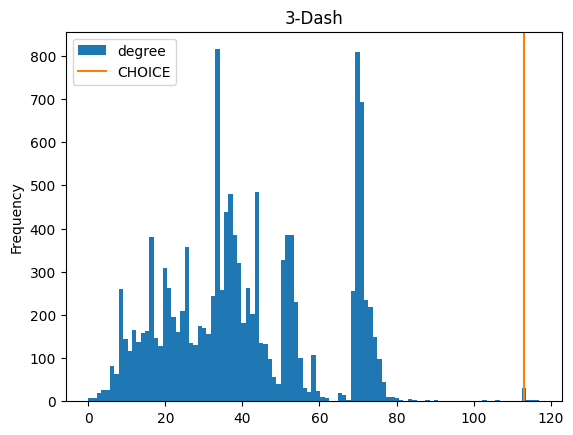

In [8]:
import matplotlib.pyplot as plt

from pmotifs.graphlet_representation import graphlet_class_to_name


graphlet_class_df = df[df["graphlet_class"] == chosen_occurrence["graphlet_class"].values[0]]
fig, ax = plt.subplots(1, 1)
bars = graphlet_class_df.plot.hist(bins=len(set(graphlet_class_df[METRIC_NAME])), ax=ax)
ax.axvline(
    pivot,
    label="CHOICE",
    color="tab:orange",
)

ax.legend()
ax.set_title(graphlet_class_to_name(chosen_occurrence["graphlet_class"].values[0]))

In [9]:
"""Prepare Graph Plotting"""
import networkx as nx

from pmotifs.analysis_utilities.plotting import prepare_kamada_kawai_layout_with_multiple_components

nx_g = g.load_graph()
pos = prepare_kamada_kawai_layout_with_multiple_components(nx_g)

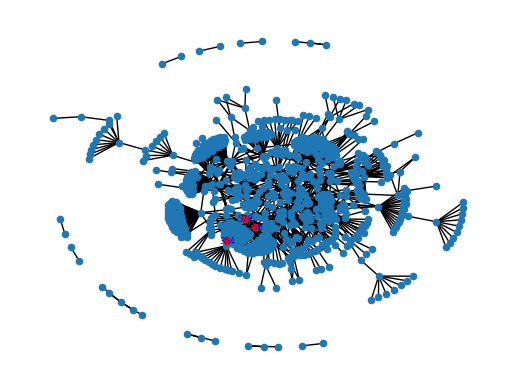

In [10]:
import matplotlib.pyplot as plt

from pmotifs.analysis_utilities.plotting import plot_graph_with_motif_highlight


fig, ax = plt.subplots(1,1)
plot_graph_with_motif_highlight(nx_g, list(chosen_occurrence.nodes), pos, ax)

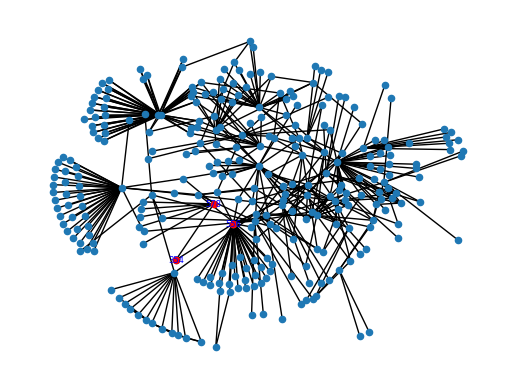

In [11]:
from pmotifs.analysis_utilities.plotting import get_zommed_graph, plot_graph_with_motif_highlight


fig, ax = plt.subplots(1,1)
plot_graph_with_motif_highlight(
    get_zommed_graph(nx_g, chosen_occurrence["nodes"].values[0]),
    chosen_occurrence["nodes"].values[0],
    pos,
    ax,
)